In [2]:
import sys, os
os.chdir("../scripts/diffuser_colored_sq")
from utils import *
from config import ConditionalTrainingConfig
import torch, random, pytz, json
from dataset import dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from model import T2IDiffusion
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os, sys, random, json
from pprint import pprint
from tqdm import tqdm
from collections import Counter, defaultdict
from PIL import Image
np.set_printoptions(precision=4)
from pprint import pprint
import textwrap
from datetime import datetime
timezone = pytz.timezone('America/New_York') 

In [48]:
ckpt = "1102_210712"
config = ConditionalTrainingConfig()
ckpt_config = json.load(open(os.path.join(config.output_dir, ckpt, "config.json"), "r"))
for k, v in ckpt_config.items():
    setattr(config, k, v)

In [49]:
test_data = dataset(
    metadata_dir=config.metadata_dir, 
    image_dir =config.image_dir, 
    split = "test"
)
test_dataloader = DataLoader(test_data, batch_size=config.eval_batch_size, shuffle=True)
test_dataiter = iter(test_dataloader)

train_data = dataset(
    metadata_dir=config.metadata_dir, 
    image_dir =config.image_dir, 
    split = "train"
)
train_dataloader = DataLoader(train_data, batch_size=config.eval_batch_size, shuffle=True)
train_dataiter = iter(train_dataloader)

In [4]:
config = ConditionalTrainingConfig()
model = T2IDiffusion(config)

config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

In [ ]:
config.mid_

In [5]:
count_parameters(model)

+----------------------------------------------------------------------------+----------+--------------------+
|                                  Modules                                   | #Params  |    Param shape     |
+----------------------------------------------------------------------------+----------+--------------------+
|                            unet.conv_in.weight                             |   1728   |   [64, 3, 3, 3]    |
|                             unet.conv_in.bias                              |    64    |        [64]        |
|                    unet.time_embedding.linear_1.weight                     |  16384   |     [256, 64]      |
|                     unet.time_embedding.linear_1.bias                      |   256    |       [256]        |
|                    unet.time_embedding.linear_2.weight                     |  65536   |     [256, 256]     |
|                     unet.time_embedding.linear_2.bias                      |   256    |       [256]        |
|

In [67]:
ckpt_dir = os.path.join(config.output_dir, ckpt, "ckpts")
load_from_epoch = "99"
load_from_pt = None
for f in os.listdir(ckpt_dir):
    if f"{load_from_epoch}_" in f: 
        load_from_pt = f
        break
print(load_from_pt)
state_dict = torch.load(os.path.join(ckpt_dir, load_from_pt), map_location="cuda:0")
model.unet.load_state_dict(state_dict)


99_33501_unet.pt


<All keys matched successfully>

In [68]:
model = model.half()
model.cuda()
model.eval()

T2IDiffusion(
  (unet): UNet2DConditionModel(
    (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=64, out_features=256, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=256, out_features=256, bias=True)
    )
    (encoder_hid_proj): Linear(in_features=4096, out_features=128, bias=True)
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (conv1): LoRACompatibleConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): LoRACompatibleLinear(in_features=256, out_features=64, bias=True)
            (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(64, 64, kernel_size=(3, 

In [69]:
print(config.metadata_dir)
train_sentences = set()
for d in train_data: train_sentences.add(d['sentence'])
test_sentences = set()
for d in test_data: test_sentences.add(d['sentence'])
train_sentences, test_sentences = list(train_sentences), list(test_sentences)
print(len(train_sentences), len(test_sentences))

../../data/matplotlib/colored_2sq/split2/
132 132


In [70]:
# Inference and save images, without visualization
date = datetime.now(timezone).strftime("%m%d_%H%M%S")

save_infr_dir = os.path.join(config.output_dir, ckpt, f"infr/train_sentences/{date}_epoch{load_from_epoch}")
os.makedirs(save_infr_dir, exist_ok=True)
for i in tqdm(range(len(train_sentences)//config.eval_batch_size+1)):
    texts = train_sentences[i*config.eval_batch_size:(i+1)*config.eval_batch_size]
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        model.inference(i, texts, save_infr_dir)
        
save_infr_dir = os.path.join(config.output_dir, ckpt, f"infr/test_sentences/{date}_epoch{load_from_epoch}")
os.makedirs(save_infr_dir, exist_ok=True)
for i in tqdm(range(len(test_sentences)//config.eval_batch_size+1)):
    texts = test_sentences[i*config.eval_batch_size:(i+1)*config.eval_batch_size]
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        model.inference(i, texts, save_infr_dir)

100%|██████████| 17/17 [00:34<00:00,  2.05s/it]


### Inference & Visualization

In [9]:
texts = next(test_dataiter)['sentence']
with torch.autocast(device_type="cuda", dtype=torch.float16):
    image_grid = model.inference("", texts, None)

100%|██████████| 100/100 [00:02<00:00, 46.24it/s]


['a black square is at the bottom of a green square. on white background.',
 'a khaki square is at the bottom of a pink square. on white background.',
 'a yellow square is on top of a pink square. on white background.',
 'a cyan square is at the bottom of a orange square. on white background.',
 'a lime square is at the bottom of a purple square. on white background.',
 'a yellow square is at the bottom of a orange square. on white background.',
 'a red square is on top of a green square. on white background.',
 'a lime square is at the bottom of a pink square. on white background.']


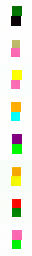

In [10]:
pprint(texts)
input_texts = texts
image_grid

In [11]:
K = 3
bs = 8
im_array = np.array(image_grid, dtype=np.float64) / 255
print(im_array.shape)
h, w, d = tuple(im_array.shape)
assert d == 3
pixels = np.reshape(im_array, (bs, h//bs, w, d))
pixels = np.reshape(pixels, (bs, -1, d))
print(pixels.shape)

(256, 32, 3)
(8, 1024, 3)


In [15]:
def visualize_single_sq(pixels, input_texts, COLORS, error_metric):
    colors_array = np.array([hex_to_rgb(v) for v in COLORS.values()]) / 255
    bs = pixels.shape[0]
    fig = plt.figure(figsize=(9, 3*bs))

    for i, m in enumerate(pixels):
        ax = fig.add_subplot(bs, 3, 3*i+1)
        ax.imshow(np.reshape(m, (-1, w, d)))
        ax.set_axis_off()
        ax.title.set_text(textwrap.fill(input_texts[i], 30))
        kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(m)
        labels = kmeans.predict(m)

        ax = fig.add_subplot(bs, 3, 3*i+2)
        background_cluster_id = int(sum([labels[0], labels[-1], labels[w-1], labels[-w]]) > 2)
        foreground_cluster_id = 1-background_cluster_id
        postproc = kmeans.cluster_centers_
        ax.imshow(postproc[labels].reshape(-1, w, d))
        ax.set_axis_off()
        
        error = error_metric([postproc[foreground_cluster_id]], colors_array)

        foreground_color = list(COLORS.keys())[error.argmin()]
        ax.title.set_text(f"foreground_color = {foreground_color}")

        ax = fig.add_subplot(bs, 3, 3*i+3)
        ax.bar(COLORS.keys(), 1-error, color=list(COLORS.keys()))
        ax.set_axis_off()
    plt.show()

In [16]:
def visualize_2sq(pixels, input_texts, COLORS, error_metric):
    colors_array = np.array([hex_to_rgb(v) for v in COLORS.values()]) / 255
    bs = pixels.shape[0]
    fig = plt.figure(figsize=(6, 3*bs))

    for i, m in enumerate(pixels):
        ax = fig.add_subplot(bs, 2, 2*i+1)
        ax.imshow(np.reshape(m, (-1, w, d)))
        ax.set_axis_off()
        ax.title.set_text(textwrap.fill(input_texts[i], 30))

        ax = fig.add_subplot(bs, 2, 2*i+2)
        kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0).fit(m)
        labels = kmeans.predict(m)
        image_size = np.sqrt(labels.shape[0])
        
        x_coords, y_coords = defaultdict(list), defaultdict(list)
        for i, l in enumerate(labels):
            x_coords[l].append(i%image_size)
            y_coords[l].append(image_size - i//image_size - 1)
        cluster_centers = {
            l: (np.mean(x_coords[l]), np.mean(y_coords[l]))
            for l in labels
        }
        cluster_centers = dict(sorted([(k, v) for k, v in cluster_centers.items()], key=lambda x: x[1][1]))
        bottom_cluster_id, background_cluster_id, top_cluster_id = list(cluster_centers.keys())

        postproc = kmeans.cluster_centers_
        ax.imshow(postproc[labels].reshape(-1, w, d))
        ax.set_axis_off()
        
        error = error_metric([postproc[top_cluster_id]], colors_array)
        top_color = list(COLORS.keys())[error.argmin()]
        error = error_metric([postproc[bottom_cluster_id]], colors_array)
        bottom_color = list(COLORS.keys())[error.argmin()]
        ax.title.set_text(f"top_color = {top_color}\nbottom_color = {bottom_color}")

        #ax = fig.add_subplot(bs, 3, 3*i+3)
        #ax.bar(COLORS.keys(), 1-error, color=list(COLORS.keys()))
        #ax.set_axis_off()
    plt.show()

In [37]:
kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0).fit(m)
labels = kmeans.predict(m)
image_size = np.sqrt(labels.shape[0])
print(image_size)
x_coords, y_coords = defaultdict(list), defaultdict(list)
for i, l in enumerate(labels):
    x_coords[l].append(i%image_size)
    y_coords[l].append(image_size - i//image_size - 1)
cluster_centers = {
    l: (np.mean(x_coords[l]), np.mean(y_coords[l]))
    for l in labels
}
cluster_centers = dict(sorted([(k, v) for k, v in cluster_centers.items()], key=lambda x: x[1][1]))
print(cluster_centers)
bottom_cluster_id, background_cluster_id, top_cluster_id = list(cluster_centers.keys())

32.0
{0: (15.5, 11.5), 1: (15.453924914675769, 15.376564277588168), 2: (16.0, 20.0)}


32.0
32.0
32.0
32.0
32.0
32.0
32.0
32.0


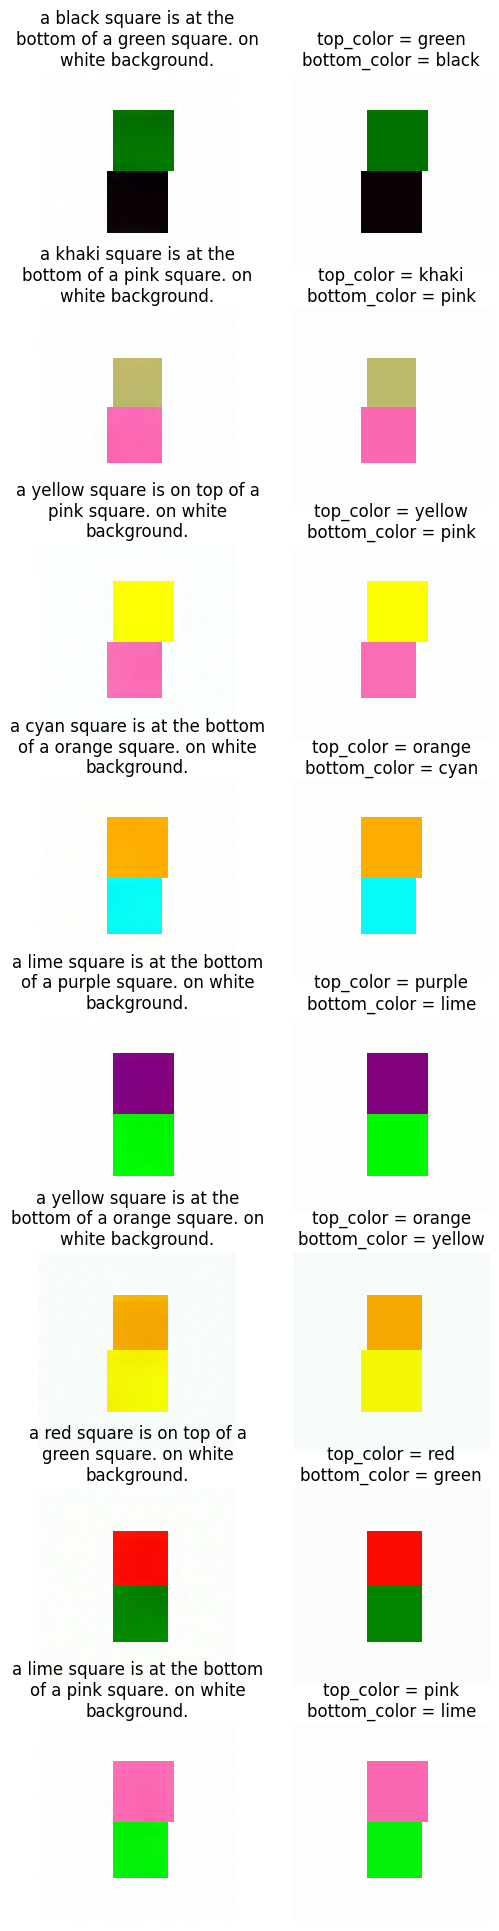

In [17]:
visualize_2sq(pixels, input_texts, COLORS, error_metric=mse)
